Server is idle at 0
job 0: t = 9, l = 0
A new job comes. Server waken up and works now at 9
Server is idle at 9
job 1: t = 21, l = 7
A new job comes. Server waken up and works now at 21
job 2: t = 23, l = 7
job 3: t = 26, l = 0
Server is idle at 36
job 4: t = 51, l = 5
A new job comes. Server waken up and works now at 51
Server is idle at 57
job 5: t = 61, l = 6
A new job comes. Server waken up and works now at 61
Server is idle at 67
job 6: t = 73, l = 14
A new job comes. Server waken up and works now at 73
job 7: t = 74, l = 1
job 8: t = 77, l = 5
job 9: t = 88, l = 4
Server is idle at 99
job 10: t = 127, l = 6
A new job comes. Server waken up and works now at 127
Server is idle at 134
job 11: t = 135, l = 3
A new job comes. Server waken up and works now at 135
Server is idle at 138
job 12: t = 146, l = 1
A new job comes. Server waken up and works now at 146
Server is idle at 148
job 13: t = 149, l = 3
A new job comes. Server waken up and works now at 149
Server is idle at 153
job 14

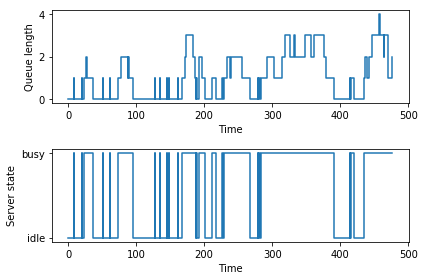

In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

INFINITE_TIME = 10000000

class Job:
    def __init__(self, id, arrtime, duration):
        self.id = id
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return 'Job %d at %d, length %d' %(self.id, self.arrtime, self.duration)

def SJF( job ):
    return job.duration

''' A server
 - env: SimPy environment
 - strat: - FIFO: First In First Out
          - SJF : Shortest Job First
'''
class Server:
    def __init__(self, env, strat = 'FIFO'):
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        ''' statistics '''
        self.waitingTime = 0
        self.idleTime = 0
        ''' register a new server process '''
        env.process( self.serve(env) )

    def serve(self, env):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.serversleeping = env.process( self.waiting( env ))
                t1 = env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += env.now - t1
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )
                qlog.write('%d\t0\t%d\t%d\t%d\n'
                           % (j.id, env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)))

                ''' sum up the waiting time'''
                self.waitingTime += env.now - j.arrtime
                ''' yield an event for the job finish'''
                yield env.timeout( j.duration )

    def waiting(self, env):
        try:
            print( 'Server is idle at %d' % env.now )
            yield env.timeout(INFINITE_TIME)
        except simpy.Interrupt as i:
            print('A new job comes. Server waken up and works now at %d' % env.now )

class JobGenerator:
    def __init__(self, env, server, maxnjobs = 2000, lam = .1, mu = .1):
        self.server = server
        self.maxnjobs = maxnjobs
        self.njobs = 0
        self.lam = lam
        self.mu = mu
        env.process( self.generatejobs(env) )

    def generatejobs(self, env):
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.expovariate( self.lam )
            yield env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            if self.njobs < self.maxnjobs:
                job_duration = random.expovariate( self.mu )
                self.server.Jobs.append( Job( self.njobs, env.now, job_duration ) )
                print( 'job %d: t = %d, l = %d' %( self.njobs, env.now, job_duration ) )
                qlog.write( '%d\t1\t%d\t%d\t%d\n'
                            % (self.njobs, env.now, 1 if len(self.server.Jobs)>0 else 0, len(self.server.Jobs)) )
                self.njobs += 1

                ''' if server is idle, wake it up'''
                if not self.server.serversleeping.triggered:
                    self.server.serversleeping.interrupt( 'Wake up, please.' )
            else:
                ''' yield a infinite timeout beyond simulation time'''
                yield env.timeout(INFINITE_TIME)

# open the log file and write header
qlog = open( 'qlength.csv', 'w' )
qlog.write( '-1\t0\t0\t0\t0\n')

# create a simulation environment
SIM_TIME = 500
env = simpy.Environment()

# create a single queue M/M/1
MU = .1
LAMBDA = .08
RHO = LAMBDA/MU
MAX_NJOBS = 10* SIM_TIME * LAMBDA

MyServer = Server( env, 'FIFO' )
MyJobGenerator = JobGenerator( env, MyServer, MAX_NJOBS, LAMBDA, MU )

# start the simulation
random.seed( 2018 )
env.run( until = SIM_TIME )

# close the log file
qlog.close()

# print statistics (mean)
if MyServer.strat == 'FIFO' and MU != LAMBDA:
    AnaMeanWaitingTime = RHO/(MU-LAMBDA)
    AnaMeanQueueLength = RHO/(1-RHO)
else:
    AnaMeanWaitingTime = -1

# print analytical performance
if MyServer.strat == 'FIFO':
    print( '-------- Analytical performance -------------')
    print( 'Mean waiting time: %.2f' % AnaMeanWaitingTime )
    print( 'Mean queue length: %.2f' % AnaMeanQueueLength )

# print simulation statistics
print( '-------- Simulation performance -------------')
print( 'Total waiting time     : %.2f' % MyServer.waitingTime )
print( 'Average waiting time   : %.2f' % (MyServer.waitingTime/MyJobGenerator.njobs) )
U = 1 - MyServer.idleTime/SIM_TIME
print( 'Total server idle time : %.2f (U=%.2f)' % (MyServer.idleTime, U) )

# plot log files
a = input( 'Do you want to plot? [y/n]' )
if a == 'y':
    # plot queue length log
    log = np.loadtxt( 'qlength.csv', delimiter='\t')
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:,2], log[:,4], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    plt.step( log[:,2], log[:,3], where='post' )
    plt.tight_layout()
    plt.show()
    %matplotlib inline